In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform=None, train = True):
        self.images_per_class = 32 if train else 8
        self.start_image = (~train) * 32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.train = train
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = list(filter(lambda s: s.endswith("jpg"), images))
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label-1])
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# torch.__version__
#import torchsample as ts

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler
torch.cuda.current_device()

from torch.optim import lr_scheduler

In [3]:
def validationSplit(trainset, ratio=0.01, random_seed=42):
    trainlen = len(trainset)
    indices = list(range(trainlen))
    split = int(np.floor(ratio*trainlen))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)    
    return train_sampler, valid_sampler

In [4]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Scale((224,224)),
     #torchvision.transforms.Scale(size, interpolation=2),
     #torchvision.transforms.CenterCrop(size),
     #torchvision.transforms.RandomCrop(size, padding=0),
     #torchvision.transforms.RandomSizedCrop(32, interpolation=2),
     transforms.ToTensor(),
     #transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

trainset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=True)
testset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=False)
"""
trainloader = DataLoader(
    dataset = caltech256_train,
    batch_size = 128,
    shuffle = True,
    num_workers = 4
)
"""
batch_size=64

train_sampler, valid_sampler = validationSplit(trainset, ratio=0.1, random_seed=47)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# kk=probe4(images)

In [6]:
class VGG_3_probe(nn.Module):
    def __init__(self):
        super(VGG_3_probe, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:-14])
        self.lastlayer = nn.Sequential(nn.Linear(256*28*28, 1024), nn.LeakyReLU(inplace=True), nn.Linear(1024, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
        #print(out.size())
        out = out.view(out.size(0), -1)
        #print(out.size())
        out = self.lastlayer(out)
        return out
    
    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [7]:
class VGG_4_probe(nn.Module):
    def __init__(self):
        super(VGG_4_probe, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:-7])
        self.lastlayer = nn.Sequential(nn.Linear(512*14*14, 1024), nn.LeakyReLU(inplace=True), nn.Linear(1024, 256))
#         self.lastlayer = nn.Sequential(nn.Linear(512*14*14, 1024), nn.Linear(1024, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())
        out = self.lastlayer(out)
#         print(out.size())
        return out
    
    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [8]:
class VGG_modified(nn.Module):
    def __init__(self):
        super(VGG_modified, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:])
        self.classifier = nn.Sequential(*list(pretrained_model.classifier.children())[:-1])
        #self.lastlayer = nn.Sequential(nn.Linear(4096, 256), nn.ReLU(inplace=True), nn.Softmax())
        self.lastlayer = nn.Sequential(nn.Linear(4096, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = self.lastlayer(out)
        return out

    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.classifier.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [9]:
class Trainer():
    def __init__(self, modelname, epochs, batchsize, lr, trainloader, validloader, testloader, model, weightdecay):
        self.epochs=epochs
        self.batch_size=batchsize
        self.learning_rate=lr
        self.train_loader=trainloader
        self.valid_loader=validloader
        self.test_loader=testloader
        self.model=model
        self.weight_decay=weightdecay
        self.modelname=modelname
        self.optimizer=torch.optim.Adam(model.lastlayer.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
    
    def getAllStats(model, loaderlist):
        model.eval()
        results={}
        criterion = nn.CrossEntropyLoss()
        for i, loader in zip(range(len(loaderlist)),loaderlist):
            correct = 0
            total = 0
            running_loss = 0
            results[i]={}
            for images, labels in loader:
                labels = labels.long()
                labels = labels.view(labels.size(0))
                labels = labels.cuda()

                images = Variable(images).cuda()
                outputs = model(images).cuda()
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()

                labels = Variable(labels)
                loss=criterion(outputs, labels)
                running_loss += loss.data[0]*images.size(0)
                
#                 loss += (criterion(outputs, labels).data[0])*images.size(0)
                
#                 print(labels.size(0), images.size(0))
            results[i]['accuracy']=((100 * correct / total))
            results[i]['loss']=((running_loss / total))
        return results

    def train(self):
        # Hyper Parameters
        num_epochs = self.epochs
        batch_size = self.batch_size
        learning_rate = self.learning_rate
        trainloader=self.train_loader
        validloader=self.valid_loader
        testloader=self.test_loader
        cnn=self.model

        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = self.optimizer

        #scheduler
        from torch.optim import lr_scheduler
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
        pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,\
                                                          patience=3, verbose=True, threshold=0.0001,
                                                          threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
        train_accuracy=[]
        train_loss=[]
        validation_accuracy=[]
        validation_loss=[]
        test_accuracy=[]
        test_loss=[]
        
        # Train the Model
        for epoch in range(num_epochs):
            running_loss = 0.0
            running_corrects = 0
            for i, (images, labels) in enumerate(trainloader):
                images = Variable(images).cuda()
                labels = labels.long()
                labels = labels.view(labels.size(0))
                labels = Variable(labels).cuda()

                optimizer.zero_grad()

                outputs = cnn(images)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.data[0]*images.size(0)
                running_corrects += torch.sum(preds == labels.data)

                loss.backward()
                optimizer.step()

                if (i+1) % 16 == 0:
                    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                           %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))    

            epoch_loss = running_loss / len(trainloader.dataset)
            epoch_acc = running_corrects*100 / len(trainloader.dataset)
            train_accuracy.append(epoch_acc)
            train_loss.append(epoch_loss)

            print("\t\t\t\t\t","training\t", "%3.10f  %3.10f" % (epoch_acc, epoch_loss))

            results=Trainer.getAllStats(cnn, [validloader, testloader])
            namedict={ 0:"validation", 1:"testing"}
            for key,val in results.items():
                if(key==0):
                    validation_accuracy.append(results[key]['accuracy'])
                    validation_loss.append(results[key]['loss'])
                else:
                    test_accuracy.append(results[key]['accuracy'])
                    test_loss.append(results[key]['loss'])
                print("\t\t\t\t\t",namedict[key],"\t", "%3.10f  %3.10f" % (results[key]['accuracy'], results[key]['loss']))

            pla_lr_scheduler.step(test_loss[-1])
        
        torch.save(cnn.state_dict(), self.modelname)
        self.saveModel(train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss)
        return train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss
    
    def saveModel(self, train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss):
        import pickle
        f = open(self.modelname+"plotdata", "wb")
        pickle.dump(train_accuracy, f)
        pickle.dump(train_loss, f)
        pickle.dump(validation_accuracy, f)
        pickle.dump(validation_loss, f)
        pickle.dump(test_accuracy, f)
        pickle.dump(test_loss, f)
        f.close()

In [11]:
cnn4 = VGG_4_probe()
cnn4.setGrads()
cnn4.initWeights()
cnn4=cnn4.cuda()

In [12]:
#useful results
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4-high-final.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.1, epochs=50, batchsize=64, lr=0.0001).train()

Epoch [1/50], Iter [16/128] Loss: 6.5228
Epoch [1/50], Iter [32/128] Loss: 4.6995
Epoch [1/50], Iter [48/128] Loss: 4.9774
Epoch [1/50], Iter [64/128] Loss: 4.7987
Epoch [1/50], Iter [80/128] Loss: 3.9700
Epoch [1/50], Iter [96/128] Loss: 3.5443
Epoch [1/50], Iter [112/128] Loss: 3.8132
					 training	 12.9760742188  4.7046487284
					 validation 	 23.3211233211  3.9198354865
					 testing 	 26.7089843750  3.7251572162
Epoch [2/50], Iter [16/128] Loss: 2.2532
Epoch [2/50], Iter [32/128] Loss: 1.3035
Epoch [2/50], Iter [48/128] Loss: 1.4684
Epoch [2/50], Iter [64/128] Loss: 1.5442
Epoch [2/50], Iter [80/128] Loss: 1.7255
Epoch [2/50], Iter [96/128] Loss: 1.2717
Epoch [2/50], Iter [112/128] Loss: 1.5465
					 training	 58.3618164062  1.5083957300
					 validation 	 33.0891330891  3.4983097019
					 testing 	 34.2285156250  3.3390414864
Epoch [3/50], Iter [16/128] Loss: 1.0142
Epoch [3/50], Iter [32/128] Loss: 0.6652
Epoch [3/50], Iter [48/128] Loss: 0.5091
Epoch [3/50], Iter [64/128] Los

Epoch [20/50], Iter [64/128] Loss: 0.2846
Epoch [20/50], Iter [80/128] Loss: 0.3123
Epoch [20/50], Iter [96/128] Loss: 0.7448
Epoch [20/50], Iter [112/128] Loss: 0.4422
					 training	 85.5590820312  0.3423722515
					 validation 	 46.2759462759  2.4636375689
					 testing 	 47.3632812500  2.4285092726
Epoch    19: reducing learning rate of group 0 to 5.0000e-05.
Epoch [21/50], Iter [16/128] Loss: 0.2320
Epoch [21/50], Iter [32/128] Loss: 0.2756
Epoch [21/50], Iter [48/128] Loss: 0.2092
Epoch [21/50], Iter [64/128] Loss: 0.1665
Epoch [21/50], Iter [80/128] Loss: 0.2509
Epoch [21/50], Iter [96/128] Loss: 0.2653
Epoch [21/50], Iter [112/128] Loss: 0.2548
					 training	 87.6586914062  0.2477876585
					 validation 	 50.3052503053  2.1958256303
					 testing 	 53.6621093750  2.1367020793
Epoch [22/50], Iter [16/128] Loss: 0.2019
Epoch [22/50], Iter [32/128] Loss: 0.1678
Epoch [22/50], Iter [48/128] Loss: 0.1478
Epoch [22/50], Iter [64/128] Loss: 0.1309
Epoch [22/50], Iter [80/128] Loss: 0

					 validation 	 56.8986568987  2.1076079291
					 testing 	 58.5937500000  2.0582759827
Epoch [39/50], Iter [16/128] Loss: 0.2250
Epoch [39/50], Iter [32/128] Loss: 0.2315
Epoch [39/50], Iter [48/128] Loss: 0.1685
Epoch [39/50], Iter [64/128] Loss: 0.1999
Epoch [39/50], Iter [80/128] Loss: 0.2017
Epoch [39/50], Iter [96/128] Loss: 0.2054
Epoch [39/50], Iter [112/128] Loss: 0.2416
					 training	 89.9658203125  0.1787775574
					 validation 	 55.6776556777  2.1243829614
					 testing 	 58.3496093750  2.0601279996
Epoch [40/50], Iter [16/128] Loss: 0.2068
Epoch [40/50], Iter [32/128] Loss: 0.1799
Epoch [40/50], Iter [48/128] Loss: 0.2076
Epoch [40/50], Iter [64/128] Loss: 0.2262
Epoch [40/50], Iter [80/128] Loss: 0.2559
Epoch [40/50], Iter [96/128] Loss: 0.2085
Epoch [40/50], Iter [112/128] Loss: 0.2201
					 training	 89.9658203125  0.1800868635
					 validation 	 57.5091575092  2.1124973012
					 testing 	 58.4960937500  2.0663821511
Epoch [41/50], Iter [16/128] Loss: 0.1897
Epoch [

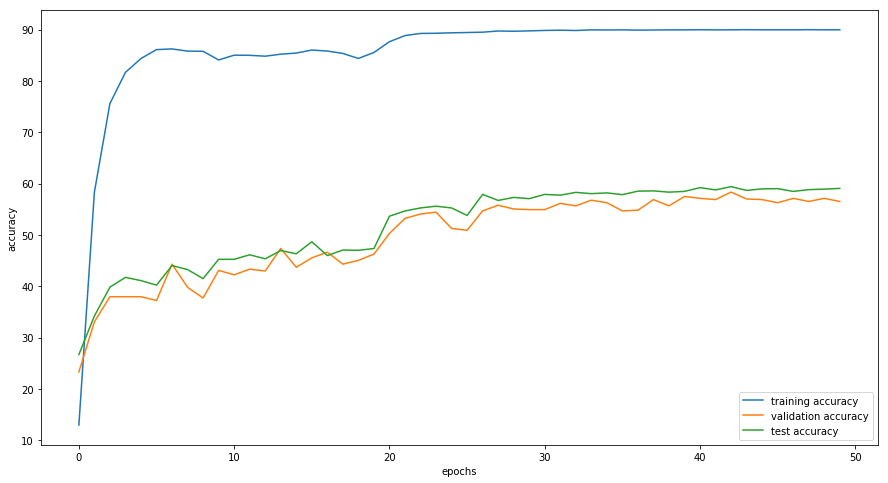

In [13]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

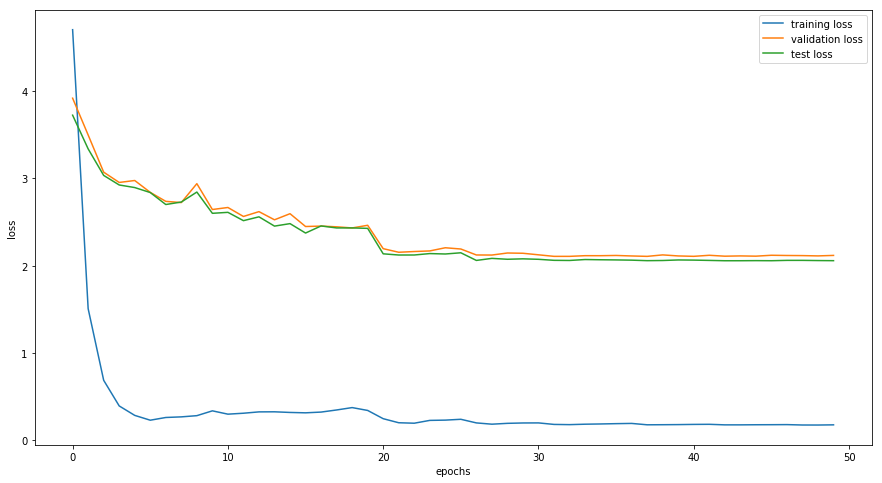

In [14]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [12]:
#useful results
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4-high-reg-try2.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.1, epochs=30, batchsize=64, lr=0.0001).train()

Epoch [1/30], Iter [16/128] Loss: 5.8283
Epoch [1/30], Iter [32/128] Loss: 4.9131
Epoch [1/30], Iter [48/128] Loss: 5.1227
Epoch [1/30], Iter [64/128] Loss: 4.8761
Epoch [1/30], Iter [80/128] Loss: 4.4950
Epoch [1/30], Iter [96/128] Loss: 4.4011
Epoch [1/30], Iter [112/128] Loss: 4.0240
					 training	 11.9750976562  4.6582022468
					 validation 	 25.1526251526  3.8741408835
					 testing 	 26.2695312500  3.8308129907
Epoch [2/30], Iter [16/128] Loss: 2.1981
Epoch [2/30], Iter [32/128] Loss: 2.1289
Epoch [2/30], Iter [48/128] Loss: 2.1119
Epoch [2/30], Iter [64/128] Loss: 1.3322
Epoch [2/30], Iter [80/128] Loss: 1.5359
Epoch [2/30], Iter [96/128] Loss: 1.2975
Epoch [2/30], Iter [112/128] Loss: 1.7007
					 training	 56.3598632812  1.6090461613
					 validation 	 40.0488400488  3.0698254630
					 testing 	 37.6464843750  3.1586161479
Epoch [3/30], Iter [16/128] Loss: 0.8874
Epoch [3/30], Iter [32/128] Loss: 0.4655
Epoch [3/30], Iter [48/128] Loss: 0.4902
Epoch [3/30], Iter [64/128] Los

Epoch [20/30], Iter [64/128] Loss: 0.5721
Epoch [20/30], Iter [80/128] Loss: 0.3376
Epoch [20/30], Iter [96/128] Loss: 0.2155
Epoch [20/30], Iter [112/128] Loss: 0.5822
					 training	 85.0219726562  0.3611518153
					 validation 	 49.0842490842  2.2373900745
					 testing 	 47.3632812500  2.4171615988
Epoch [21/30], Iter [16/128] Loss: 0.4953
Epoch [21/30], Iter [32/128] Loss: 0.2976
Epoch [21/30], Iter [48/128] Loss: 0.3581
Epoch [21/30], Iter [64/128] Loss: 0.5710
Epoch [21/30], Iter [80/128] Loss: 0.4855
Epoch [21/30], Iter [96/128] Loss: 0.5381
Epoch [21/30], Iter [112/128] Loss: 0.6825
					 training	 84.9243164062  0.3721189279
					 validation 	 54.3345543346  2.1541867879
					 testing 	 48.4375000000  2.3153175004
Epoch [22/30], Iter [16/128] Loss: 0.3422
Epoch [22/30], Iter [32/128] Loss: 0.5358
Epoch [22/30], Iter [48/128] Loss: 0.2839
Epoch [22/30], Iter [64/128] Loss: 0.3932
Epoch [22/30], Iter [80/128] Loss: 0.4837
Epoch [22/30], Iter [96/128] Loss: 0.5426
Epoch [22/30],

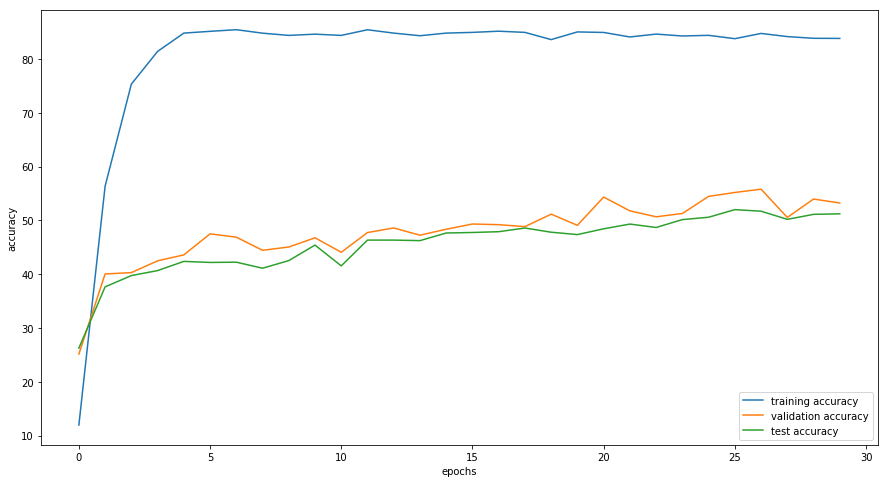

In [13]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

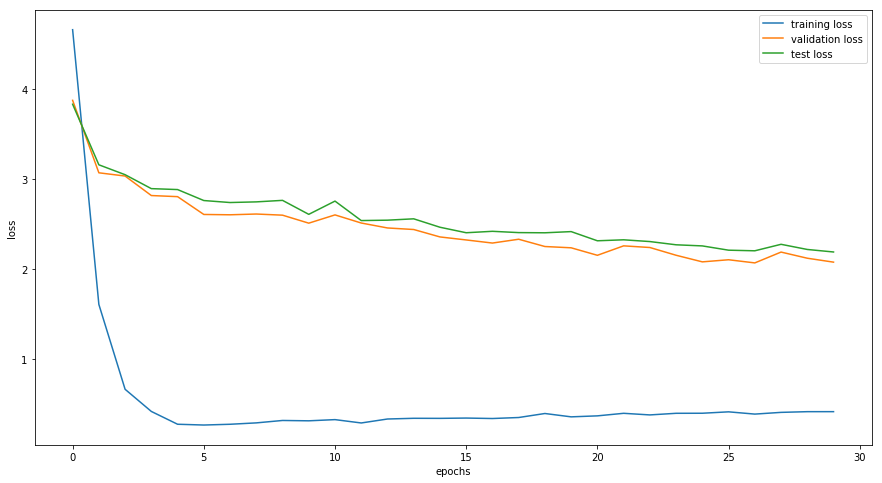

In [14]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [25]:
#useful results
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4-high-reg.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.1, epochs=20, batchsize=64, lr=0.00005).train()

Epoch [1/20], Iter [16/128] Loss: 5.8855
Epoch [1/20], Iter [32/128] Loss: 5.2445
Epoch [1/20], Iter [48/128] Loss: 5.1817
Epoch [1/20], Iter [64/128] Loss: 4.5743
Epoch [1/20], Iter [80/128] Loss: 4.6730
Epoch [1/20], Iter [96/128] Loss: 4.2489
Epoch [1/20], Iter [112/128] Loss: 3.5233
					 training	 11.0473632812  4.6433305611
					 validation 	 25.6410256410  3.9165125388
					 testing 	 24.8535156250  3.9666726291
Epoch [2/20], Iter [16/128] Loss: 1.7866
Epoch [2/20], Iter [32/128] Loss: 1.5032
Epoch [2/20], Iter [48/128] Loss: 1.6996
Epoch [2/20], Iter [64/128] Loss: 1.2649
Epoch [2/20], Iter [80/128] Loss: 1.5329
Epoch [2/20], Iter [96/128] Loss: 1.0053
Epoch [2/20], Iter [112/128] Loss: 1.2450
					 training	 59.1430664062  1.5027394549
					 validation 	 35.6532356532  3.1996415564
					 testing 	 36.1816406250  3.3097328693
Epoch [3/20], Iter [16/128] Loss: 0.8413
Epoch [3/20], Iter [32/128] Loss: 0.7327
Epoch [3/20], Iter [48/128] Loss: 0.9590
Epoch [3/20], Iter [64/128] Los

Epoch [20/20], Iter [64/128] Loss: 0.2648
Epoch [20/20], Iter [80/128] Loss: 0.2763
Epoch [20/20], Iter [96/128] Loss: 0.2901
Epoch [20/20], Iter [112/128] Loss: 0.3596
					 training	 87.5488281250  0.2274879530
					 validation 	 50.9157509158  2.2881696425
					 testing 	 47.3632812500  2.4360294268


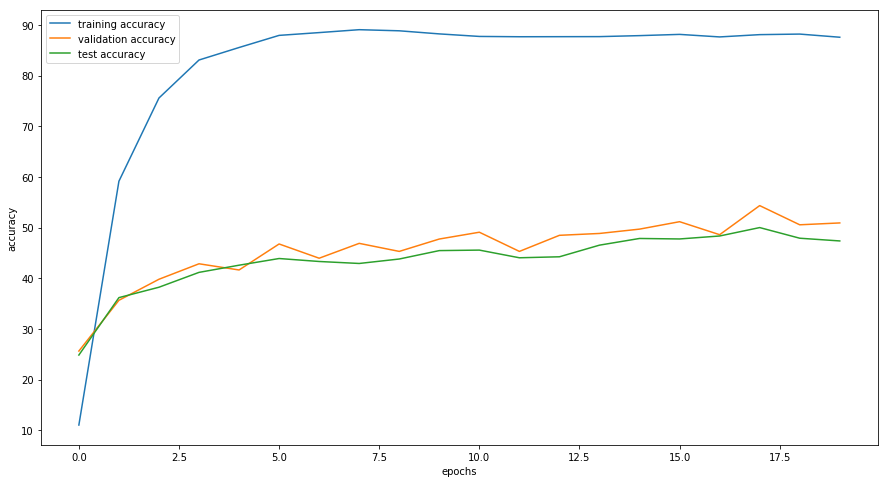

In [26]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

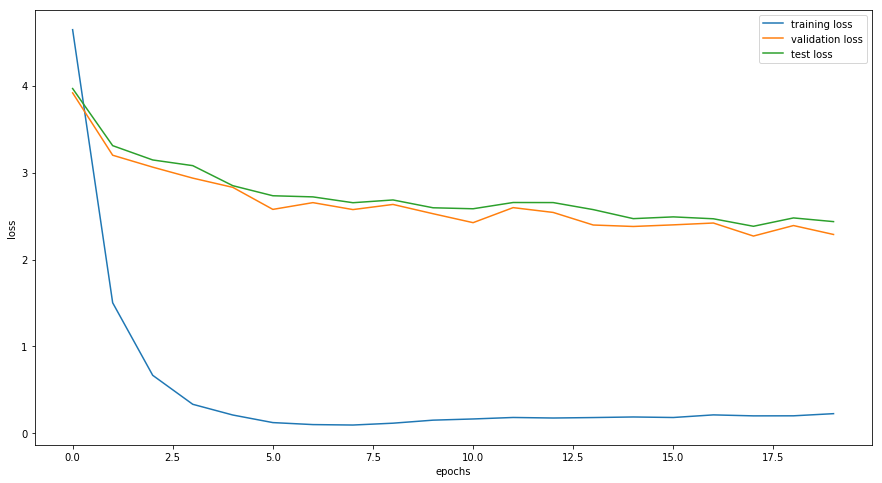

In [27]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.01, epochs=20, batchsize=64, lr=0.0001).train()

Epoch [1/20], Iter [16/128] Loss: 6.5876
Epoch [1/20], Iter [32/128] Loss: 4.8818
Epoch [1/20], Iter [48/128] Loss: 4.8621
Epoch [1/20], Iter [64/128] Loss: 4.6559
Epoch [1/20], Iter [80/128] Loss: 4.5611
Epoch [1/20], Iter [96/128] Loss: 3.7032
Epoch [1/20], Iter [112/128] Loss: 3.7895
					 training	 12.4023437500  4.6476789280
					 validation 	 24.4200244200  3.8903351302
					 testing 	 25.0488281250  3.9246604592
Epoch [2/20], Iter [16/128] Loss: 2.3476
Epoch [2/20], Iter [32/128] Loss: 1.9466
Epoch [2/20], Iter [48/128] Loss: 1.4574
Epoch [2/20], Iter [64/128] Loss: 1.6496
Epoch [2/20], Iter [80/128] Loss: 1.5025
Epoch [2/20], Iter [96/128] Loss: 2.0123
Epoch [2/20], Iter [112/128] Loss: 1.7733
					 training	 58.3496093750  1.5313919728
					 validation 	 36.0195360195  3.2929043240
					 testing 	 33.2031250000  3.5018531159
Epoch [3/20], Iter [16/128] Loss: 0.6576
Epoch [3/20], Iter [32/128] Loss: 0.3962
Epoch [3/20], Iter [48/128] Loss: 0.5267
Epoch [3/20], Iter [64/128] Los

Epoch [20/20], Iter [32/128] Loss: 0.0078
Epoch [20/20], Iter [48/128] Loss: 0.0094
Epoch [20/20], Iter [64/128] Loss: 0.0204
Epoch [20/20], Iter [80/128] Loss: 0.0387
Epoch [20/20], Iter [96/128] Loss: 0.0088
Epoch [20/20], Iter [112/128] Loss: 0.0196
					 training	 89.2944335938  0.0331267940
					 validation 	 48.1074481074  3.0269207183
					 testing 	 44.4824218750  3.0904443637


In [13]:
#old one
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.0001, epochs=20, batchsize=64, lr=0.001).train()

Epoch [1/20], Iter [16/128] Loss: 96.9283
Epoch [1/20], Iter [32/128] Loss: 24.4435
Epoch [1/20], Iter [48/128] Loss: 9.4226
Epoch [1/20], Iter [64/128] Loss: 5.8612
Epoch [1/20], Iter [80/128] Loss: 5.0807
Epoch [1/20], Iter [96/128] Loss: 5.2775
Epoch [1/20], Iter [112/128] Loss: 4.9297
					 training	 7.4218750000  21.7034251356
					 validation 	 18.4371184371  4.4785710447
					 testing 	 20.1171875000  4.4782221839
Epoch [2/20], Iter [16/128] Loss: 3.1824
Epoch [2/20], Iter [32/128] Loss: 3.3120
Epoch [2/20], Iter [48/128] Loss: 3.1076
Epoch [2/20], Iter [64/128] Loss: 3.9147
Epoch [2/20], Iter [80/128] Loss: 2.7414
Epoch [2/20], Iter [96/128] Loss: 2.6889
Epoch [2/20], Iter [112/128] Loss: 2.8681
					 training	 37.4389648438  2.7394381348
					 validation 	 24.1758241758  4.4714100428
					 testing 	 23.0957031250  4.4263933003
Epoch [3/20], Iter [16/128] Loss: 1.8592
Epoch [3/20], Iter [32/128] Loss: 1.7759
Epoch [3/20], Iter [48/128] Loss: 1.7797
Epoch [3/20], Iter [64/128] L

					 validation 	 38.5836385836  4.5326772901
					 testing 	 37.6464843750  4.8145020977
Epoch [20/20], Iter [16/128] Loss: 0.0258
Epoch [20/20], Iter [32/128] Loss: 0.0067
Epoch [20/20], Iter [48/128] Loss: 0.0092
Epoch [20/20], Iter [64/128] Loss: 0.0086
Epoch [20/20], Iter [80/128] Loss: 0.0055
Epoch [20/20], Iter [96/128] Loss: 0.0143
Epoch [20/20], Iter [112/128] Loss: 0.0126
					 training	 89.9536132812  0.0078389235
					 validation 	 38.7057387057  4.4583088295
					 testing 	 37.2558593750  4.7897209227


In [ ]:
cnn5 = VGG_modified()
cnn5.setGrads()
cnn5.initWeights()
cnn5=cnn5.cuda()

In [25]:
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_5.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn5,\
        weightdecay=0.0001, epochs=20, batchsize=64, lr=0.001).train()

Epoch [1/20], Iter [16/128] Loss: 4.9449
Epoch [1/20], Iter [32/128] Loss: 3.3836
Epoch [1/20], Iter [48/128] Loss: 1.8938
Epoch [1/20], Iter [64/128] Loss: 1.7861
Epoch [1/20], Iter [80/128] Loss: 1.1555
Epoch [1/20], Iter [96/128] Loss: 1.0730
Epoch [1/20], Iter [112/128] Loss: 1.7500
					 training	 41.9067382812  2.3734494501
					 validation 	 70.9401709402  1.1285482609
					 testing 	 72.4121093750  1.0929679591
Epoch [2/20], Iter [16/128] Loss: 0.6372
Epoch [2/20], Iter [32/128] Loss: 0.6975
Epoch [2/20], Iter [48/128] Loss: 0.5905
Epoch [2/20], Iter [64/128] Loss: 0.4337
Epoch [2/20], Iter [80/128] Loss: 0.4067
Epoch [2/20], Iter [96/128] Loss: 0.7967
Epoch [2/20], Iter [112/128] Loss: 0.5908
					 training	 76.9897460938  0.5020256519
					 validation 	 73.5042735043  1.0890314632
					 testing 	 74.4140625000  1.0067960881
Epoch [3/20], Iter [16/128] Loss: 0.2281
Epoch [3/20], Iter [32/128] Loss: 0.1304
Epoch [3/20], Iter [48/128] Loss: 0.1811
Epoch [3/20], Iter [64/128] Los

Process Process-69:
KeyboardInterrupt
Process Process-71:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process Process-70:
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])


KeyboardInterrupt: 

  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process Process-72:
  File "<ipython-input-1-a8506a27fb22>", line 61, in __getitem__
    image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/site-packages/PIL/Image.py", line 875, in convert
    self.load()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/site-packages/PIL/ImageFile.py", line 236, in load
    n, err_code = decoder.decode(b)
Traceback (most recent call last):
KeyboardInterrupt
  Fil

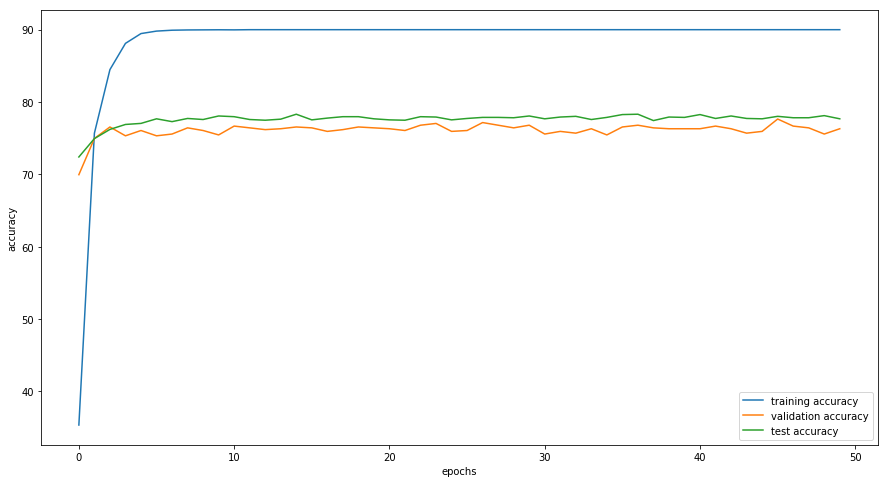

In [16]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()